# Andres - XGBoost Model

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (10, 6)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

---
### Data Loading

In [ ]:
# Load data
X_train = pd.read_csv('cleaned_x_train.csv')
y_train = pd.read_csv('cleaned_y_train.csv')['risky_drinking'].values

X_val = pd.read_csv('cleaned_x_val.csv')
y_val = pd.read_csv('cleaned_y_val.csv')['risky_drinking'].values

X_test = pd.read_csv('cleaned_x_test.csv')
y_test = pd.read_csv('cleaned_y_test.csv')['risky_drinking'].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (24158, 25)
X_val shape: (5178, 25)
X_test shape: (5177, 25)


In [3]:
print(X_train.columns.tolist())

['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEADSAF', 'ACEADNED', '_EDUCAG', '_AGE80', '_SEX', 'MENTHLTH', 'PHYSHLTH', '_SMOKER3', 'race_2.0', 'race_3.0', 'race_4.0', 'race_5.0', 'race_6.0', 'at_least_1_ace', 'ACE_SCORE']


In [4]:
print("Class distribution")
print(f"Risky drinking: {y_train.sum():,} ({y_train.mean():.1%})")
print(f"Not risky: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")

Class distribution
Risky drinking: 9,110 (37.7%)
Not risky: 15,048 (62.3%)


#### Downsample Majority Class

In [5]:
minority_indices = np.where(y_train == 1)[0]
majority_indices = np.where(y_train == 0)[0]

# sample from majority class
np.random.seed(RANDOM_SEED)
downsampled_majority_indices = np.random.choice(majority_indices, size=len(minority_indices), replace=False)

# combine indices
balanced_indices = np.concatenate([minority_indices, downsampled_majority_indices])
np.random.shuffle(balanced_indices)

# create balanced training set
X_train_balanced = X_train.iloc[balanced_indices].reset_index(drop=True)
y_train_balanced = y_train[balanced_indices]

---
### Baseline Model

In [6]:
# Majority class baseline
majority_class = 0 if (y_train == 0).sum() > (y_train == 1).sum() else 1
baseline_preds = np.full(len(y_test), majority_class)
baseline_accuracy = accuracy_score(y_test, baseline_preds)
baseline_recall = recall_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds)

print("Majority class:", majority_class)
print("Baseline accuracy:", baseline_accuracy)
print("Baseline recall:", baseline_recall)
print("Baseline F1:", baseline_f1)

Majority class: 0
Baseline accuracy: 0.6229476530809349
Baseline recall: 0.0
Baseline F1: 0.0


---
### Initial XGBoost Model

In [7]:
# Train initial model with default parameters on balanced data
initial_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)
initial_model.fit(X_train_balanced, y_train_balanced)

# Validation performance
y_val_pred = initial_model.predict(X_val)
print("Initial Model (Validation):")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))

Initial Model (Validation):
Accuracy: 0.6120123599845501
F1 Score: 0.5606822654712442


---
### Hyperparameter Tuning

In [8]:
param_grid = {
    'n_estimators': [10, 15, 20, 50, 75, 100],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'learning_rate': [0.001, 0.01, 0.07, 0.1, 0.13, 0.2],
    'min_child_weight': [1, 2, 3, 4, 5, 6]
}

In [9]:
# Run GridSearchCV
base_model = XGBClassifier(random_state=RANDOM_SEED, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_balanced, y_train_balanced)

print(f"Best CV F1 score: {grid_search.best_score_:.4f}")
print(f"Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best CV F1 score: 0.6454
Best parameters:
  learning_rate: 0.1
  max_depth: 4
  min_child_weight: 6
  n_estimators: 75


---
### Final Model

In [10]:
# Train final model
best_params = grid_search.best_params_
final_model = XGBClassifier(**best_params, random_state=RANDOM_SEED, eval_metric='logloss')
final_model.fit(X_train_balanced, y_train_balanced)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
# Validation performance
y_val_pred = final_model.predict(X_val)
y_val_proba = final_model.predict_proba(X_val)[:, 1]

print("Final Model (Validation):")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

Final Model (Validation):
Accuracy: 0.6139436075704905
Precision: 0.491307634164777
Recall: 0.6656426011264721
F1 Score: 0.5653402913676886
ROC-AUC: 0.6797982035191337


#### Loss Curves

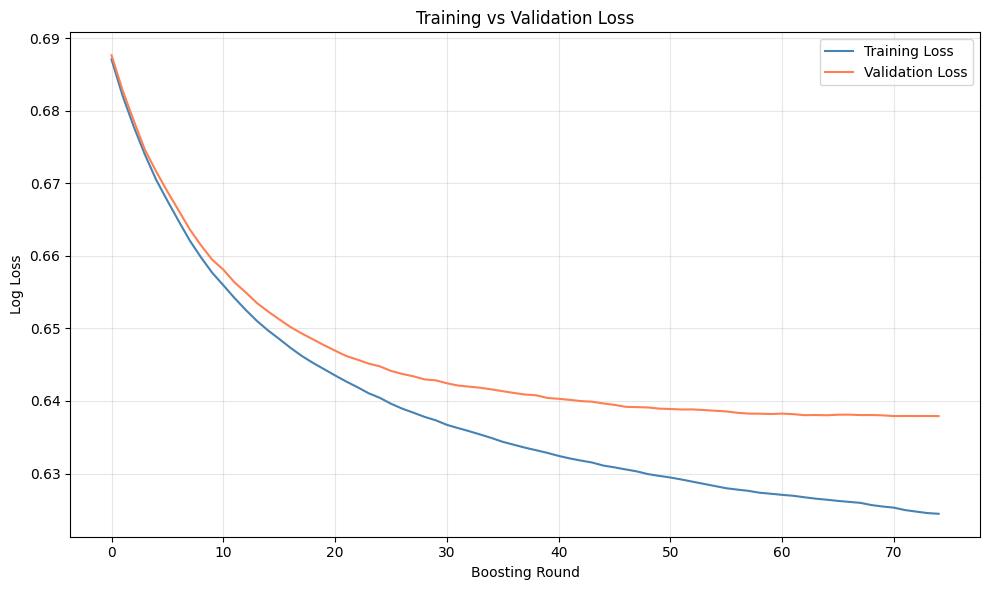

Final training loss: 0.6244
Final validation loss: 0.6379
Loss difference: 0.0135


In [12]:
# Train model with eval_set
eval_model = XGBClassifier(**best_params, random_state=RANDOM_SEED, eval_metric='logloss')
eval_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_train_balanced, y_train_balanced), (X_val, y_val)],
    verbose=False
)

# Get loss values
results = eval_model.evals_result()
train_loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Plot loss curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(train_loss, label='Training Loss', color='steelblue')
ax.plot(val_loss, label='Validation Loss', color='coral')
ax.set_xlabel('Boosting Round')
ax.set_ylabel('Log Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Final validation loss: {val_loss[-1]:.4f}")
print(f"Loss difference: {abs(train_loss[-1] - val_loss[-1]):.4f}")

---
### Test Set Evaluation

In [13]:
# Test predictions
y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("Test Set Performance:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print("ROC-AUC:", test_roc_auc)

Test Set Performance:
Accuracy: 0.6254587598995557
Precision: 0.5023542194856936
Recall: 0.7105532786885246
F1 Score: 0.5885847655421176
ROC-AUC: 0.6967585620790443


In [14]:
print("Baseline:", baseline_accuracy)
print("Improvement:", test_accuracy - baseline_accuracy)

Baseline: 0.6229476530809349
Improvement: 0.0025111068186207675


In [15]:
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Not Risky', 'Risky']))

Classification Report:
              precision    recall  f1-score   support

   Not Risky       0.77      0.57      0.66      3225
       Risky       0.50      0.71      0.59      1952

    accuracy                           0.63      5177
   macro avg       0.63      0.64      0.62      5177
weighted avg       0.67      0.63      0.63      5177



#### Confusion Matrices (Train, Validation, Test)

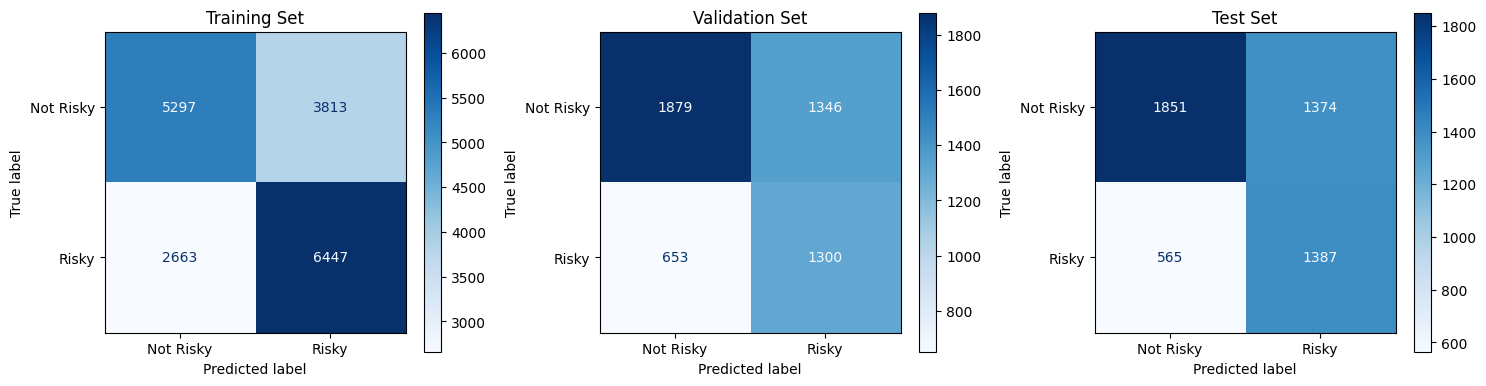

In [16]:
# Get predictions for train and validation
y_train_pred = final_model.predict(X_train_balanced)
y_val_pred = final_model.predict(X_val)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Training confusion matrix
cm_train = confusion_matrix(y_train_balanced, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Not Risky', 'Risky']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Training Set')

# Validation confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Not Risky', 'Risky']).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Validation Set')

# Test confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Not Risky', 'Risky']).plot(ax=axes[2], cmap='Blues')
axes[2].set_title('Test Set')

plt.tight_layout()
plt.show()

#### ROC Curve

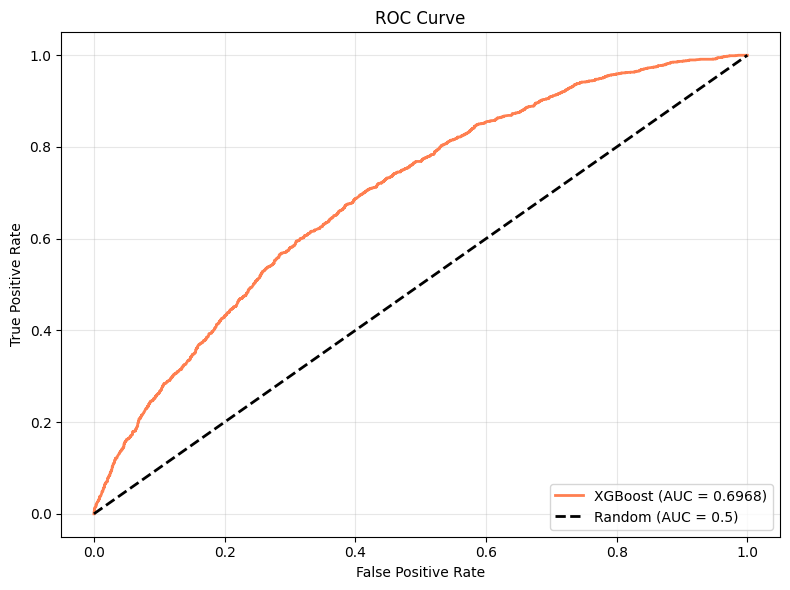

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='coral', lw=2, label=f'XGBoost (AUC = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
### Subgroup Analysis

In [18]:
def subgroup_metrics(y_true, y_pred, name, n):
    return {
        'Subgroup': name, 'N': n,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    }

#### By Sex

In [19]:
sex_results = []
for val, name in [(0, 'Male'), (1, 'Female')]:
    mask = X_test['_SEX'] == val
    sex_results.append(subgroup_metrics(y_test[mask], y_test_pred[mask], name, mask.sum()))

sex_df = pd.DataFrame(sex_results)
print("Performance by Sex:")
print(sex_df.to_string(index=False))

Performance by Sex:
Subgroup    N  Accuracy  Precision   Recall       F1
    Male 2357  0.586763   0.534004 0.829201 0.649640
  Female 2820  0.657801   0.452336 0.560834 0.500776


#### By Age Group

In [20]:
age_bins = [(18, 30, '18-29'), (30, 45, '30-44'), (45, 60, '45-59'), (60, 100, '60+')]
age_results = []
for lo, hi, name in age_bins:
    mask = (X_test['_AGE80'] >= lo) & (X_test['_AGE80'] < hi)
    if mask.sum() > 0:
        age_results.append(subgroup_metrics(y_test[mask], y_test_pred[mask], name, mask.sum()))

age_df = pd.DataFrame(age_results)
print("Performance by Age Group:")
print(age_df.to_string(index=False))

Performance by Age Group:
Subgroup    N  Accuracy  Precision   Recall       F1
   18-29  512  0.650391   0.591331 0.802521 0.680927
   30-44  851  0.572268   0.522273 0.865140 0.651341
   45-59 1117  0.585497   0.497878 0.765217 0.603256
     60+ 2697  0.654060   0.466667 0.585366 0.519320


#### By Race

In [21]:
race_results = []

# White
white = (X_test['race_2.0']==0) & (X_test['race_3.0']==0) & (X_test['race_4.0']==0) & (X_test['race_5.0']==0) & (X_test['race_6.0']==0)
race_results.append(subgroup_metrics(y_test[white], y_test_pred[white], 'White', white.sum()))

# Black
black = X_test['race_2.0'] == 1
if black.sum() > 0:
    race_results.append(subgroup_metrics(y_test[black], y_test_pred[black], 'Black', black.sum()))

# Other
other = (X_test['race_3.0']==1) | (X_test['race_4.0']==1) | (X_test['race_5.0']==1) | (X_test['race_6.0']==1)
if other.sum() > 0:
    race_results.append(subgroup_metrics(y_test[other], y_test_pred[other], 'Other', other.sum()))

race_df = pd.DataFrame(race_results)
print("Performance by Race:")
print(race_df.to_string(index=False))

Performance by Race:
Subgroup    N  Accuracy  Precision   Recall       F1
   White 3092  0.600259   0.526799 0.769575 0.625455
   Black  542  0.642066   0.423423 0.587500 0.492147
   Other 1543  0.670123   0.450000 0.578714 0.506305


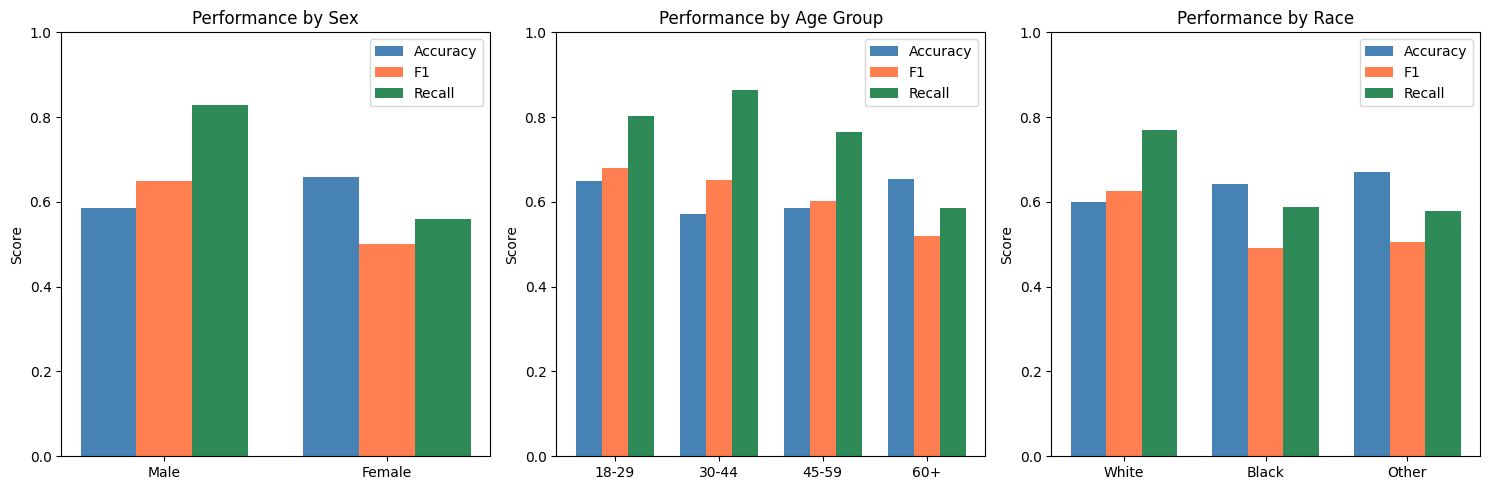

In [22]:
# Visualize subgroup performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (df, title) in zip(axes, [(sex_df, 'Sex'), (age_df, 'Age Group'), (race_df, 'Race')]):
    x = np.arange(len(df))
    w = 0.25
    ax.bar(x - w, df['Accuracy'], w, label='Accuracy', color='steelblue')
    ax.bar(x, df['F1'], w, label='F1', color='coral')
    ax.bar(x + w, df['Recall'], w, label='Recall', color='seagreen')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Subgroup'])
    ax.set_ylabel('Score')
    ax.set_title(f'Performance by {title}')
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()